# Transient Universe: MCMC Sampling

### WIP - Unfinished!

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
import corner

#Big figures
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [80]:
data = np.load('../solutions/transient.npy')

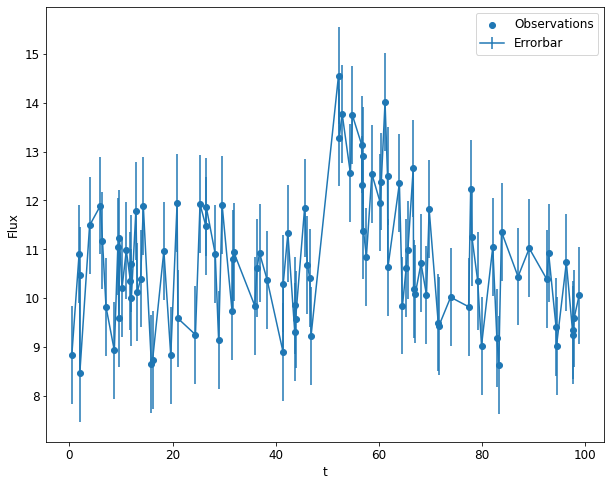

In [81]:
#Unpacking and visualizing data
#t = data[:, 0]
#flux = data[:, 1]
#flux_err = data[:, 2]

#Way faster unpacking
t, flux, flux_err = data.T

#Plotting with errors
plt.scatter(t, flux, label='Observations')
plt.errorbar(t, flux, yerr=flux_err, label='Errorbar')
plt.xlabel('t')
plt.ylabel('Flux')
plt.legend()
plt.show()

Burst model approximation in which signal is:

$y = b$ if  $t < t_{0}$

$y = b + A\cdot \exp[-\alpha(t-t_{0}])$ if  $t \geq t_{0}$

In [123]:
#Function modeling Signal: Noise + Exponential decay
def fun_model(parameters, t):

    b, t_0, A, alpha = parameters.T

    return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))

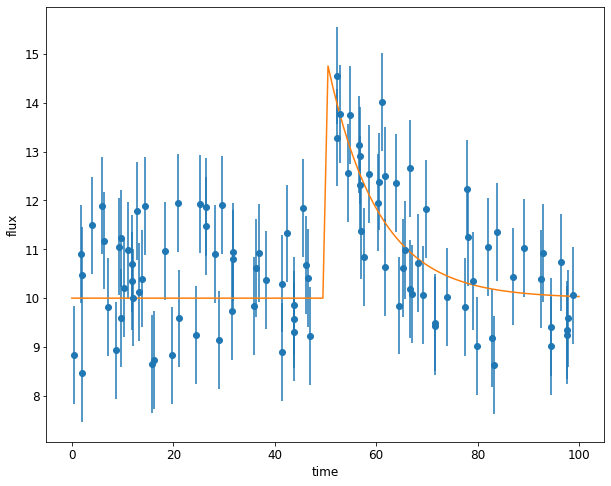

In [124]:
#Eyeball estimate
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1

theta_quick= np.array([b_quick, t0_quick, A_quick, alpha_quick])

#Evaluating the function
ygrid = fun_model(theta_quick, tgrid)

plt.errorbar(t, flux ,yerr=flux_err, fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid, ygrid);

## EMCEE

In [84]:
def loglike(theta, data, model):
    t, flux, flux_err = data.T

    #Computing theoretical flux
    flux_theoretical = model(theta, t)
    
    #Gaussian Log-Likelihood -> Distance from theoretical value
    logL = -0.5 * np.sum(((flux - flux_theoretical)**2 / (flux_err)**2))

    return logL

def logprior(theta):
    #Priors initialization
    t0min, t0max = 0, 100
    Amin, Amax = 0, 50
    bmin, bmax = 0, 50
    alphamin, alphamax = np.exp(-5), np.exp(5)


    A,b,t0,alpha=theta

    if (Amin < A < Amax) and (bmin < b < bmax) and (t0min < t0 < t0max) and (alphamin < alpha < alphamax):
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf

def logposterior(theta, data, model):
    return loglike(theta, data, model) + logprior(theta)

In [91]:
#Number of free parameters
ndim = 4

#Sampler walkers
nwalkers = 5 * ndim

#Steps that each walker takes -> Number of samples per walker
steps = 10000

starting_guesses = theta_quick + 1e-1* np.random.randn(nwalkers, ndim)

In [92]:
#Sampler setup
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[data, fun_model])

#Sampling
sampler.run_mcmc(starting_guesses, steps);

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


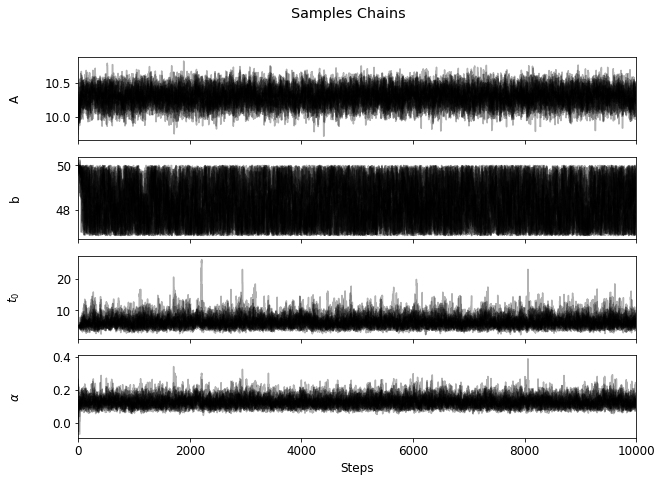

In [93]:
#Gather chains
samples = sampler.get_chain()

#Plotting chains
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ['A', 'b', r'$t_{0}$', r'$\alpha$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c='k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig.suptitle('Samples Chains')
axes[-1].set_xlabel('Steps');

In [94]:
tau = sampler.get_autocorr_time()

In [95]:
tau

array([52.72823048, 61.06528322, 62.57327916, 59.88783117])

In [97]:
thinned_samples = sampler.get_chain(discard=int(max(tau)), thin=int(max(tau)), flat=True)

In [131]:
thinned_samples.shape

(3200, 4)

In [164]:
theta_median, quantile = [], []
for i in range(4):
    theta_median.append(np.median(thinned_samples[:, i]))
    quantile.append(np.quantile(thinned_samples[:, i], q=[0.10, 0.90]))

theta_median = np.array(theta_median)
quantile = np.array(quantile)


In [165]:
quantile

array([[10.14231517, 10.45152552],
       [47.10807096, 49.61043215],
       [ 4.61650601,  8.57197782],
       [ 0.09401571,  0.16195042]])

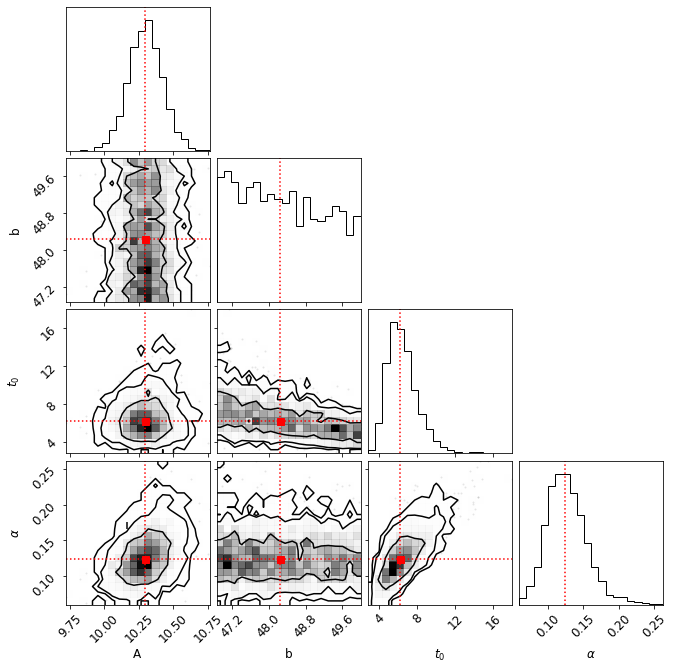

In [167]:
#Contours
levels = [0.68, 0.95, 0.99]

#Corner Plot
cornerplot = corner.corner(thinned_samples, labels=labels, levels=levels)


#Overplotting median values and 90% C.I.
corner.overplot_lines(cornerplot, theta_median, color='red', ls=':')
corner.overplot_points(cornerplot, theta_median[None], marker='s', markersize=7, color='red')
#corner.overplot_lines(cornerplot, quantile, color='black')


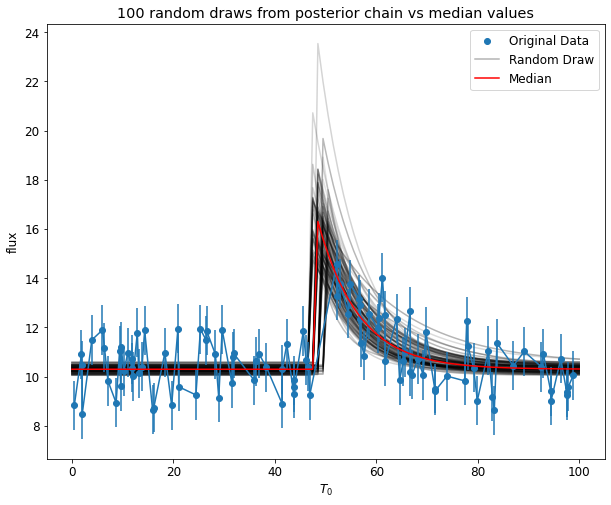

In [168]:
#Showing 100 random samples from posterior chains vs Median values
tgrid=np.linspace(0,100,100)
new_theta = []
draws = 100

for i in range(ndim):
    new_theta.append(np.random.choice(thinned_samples[:, i], draws))

new_theta = np.array(new_theta)

#Plotting
plt.scatter(t, flux, zorder=1, label='Original Data')
plt.errorbar(t, flux, yerr=flux_err, zorder=0)

plt.plot(tgrid, fun_model(new_theta[:, 0], tgrid), c='k', alpha=0.3, zorder=-1, label='Random Draw')

opacity = np.linspace(0.1, 0.3, 100)
for i, j in zip(range(1, 100), opacity):
    plt.plot(tgrid, fun_model(new_theta[:, i], tgrid), c='k', alpha=j, zorder=-1)

plt.plot(tgrid, fun_model(theta_median, tgrid), c='red', zorder=2, label='Median')
plt.xlabel(r'$T_{0}$')
plt.ylabel('flux')
plt.title('{} random draws from posterior chain vs median values'.format(draws))
plt.legend()
plt.show()